In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as datetime
import plotly
import matplotlib.ticker as mticker
import plotly.graph_objects as go


plt.style.use('ggplot')
sns.set_palette('husl')


df = pd.read_csv('eda_data.csv', on_bad_lines='skip')
if df is not None and not df.empty:
    print("DatFrame loaded successfully.")
else:
    print("Error.")

df['invoice_date']=pd.to_datetime(df['invoice_date'])
                                     



DatFrame loaded successfully.


In [2]:
pd.set_option('display.float_format', '{:.2f}'.format)
print(df[["quantity","unit_price","total"]].describe())
print(f"\nDataset Shape: {df.shape}")


       quantity  unit_price      total
count 541802.00   541802.00  541802.00
mean       9.55        4.61      17.99
std      218.10       96.77     378.85
min   -80995.00   -11062.06 -168469.60
25%        1.00        1.25       3.40
50%        3.00        2.08       9.75
75%       10.00        4.13      17.40
max    80995.00    38970.00  168469.60

Dataset Shape: (541802, 10)


In [40]:
#create column to distinguish "customer" and "guest"
df['user_type'] = np.where(df['customer_id'].notna(), 'customer', 'guest')

#slice df to focus on "sale" events
sales_df= df[df['transaction_type']=='sale']

#slice df to focus on "return" events
return_df = df[df['transaction_type'] == 'return']


In [29]:
print("\nColumns:")
print(df.columns)
print("\nData Types:")
print(df.dtypes)


Columns:
Index(['invoice_no', 'product_id', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country', 'transaction_type', 'total',
       'user_type'],
      dtype='object')

Data Types:
invoice_no                  object
product_id                  object
description                 object
quantity                     int64
invoice_date        datetime64[ns]
unit_price                 float64
customer_id                float64
country                     object
transaction_type            object
total                      float64
user_type                   object
dtype: object


In [17]:
# Transaction Analysis
print("\n3. Transaction Analysis")
print("=" * 50)
print("Transaction Types Distribution:")
print(df['transaction_type'].value_counts())


3. Transaction Analysis
Transaction Types Distribution:
transaction_type
sale          531176
return         10624
adjustment         2
Name: count, dtype: int64


In [44]:
print("\nInvoice Analysis:")
print("Unique Invoices:")
print(df['invoice_no'].nunique())

inv_avg_sales = sales_df.groupby('invoice_no').size().mean()
print(f"Average number of sales per invoice: {inv_avg_sales:.2f}")

inv_avg_returns = return_df.groupby('invoice_no').size().mean()
print(f"Average number of returns per invoice: {inv_avg_returns:.2f}")

inv_avg_per_customer = (sales_df & (df['user_type'] == 'customer').groupby('customer_id')['invoice_no'].nunique().mean())
print(f"Average number of invoices per customer: {inv_avg_per_customer:.2f}")

#I want to add this
avg_item_invoice = sales_df



Invoice Analysis:
Unique Invoices:
25898
Average number of sales per invoice: 25.63
Average number of returns per invoice: 2.05


KeyError: 'customer_id'

In [4]:
#Having noticed huge outliers of probable fat finger purchases (bought and immediately returned) 
#I will remove those outliers from the distribution analysis (Boxplots, histograms, Violin plots)

# Finding the top 3 largest positive outliers
positive_outliers = df[df['total'] > 0]['total'].nlargest(3)

# Finding the top 3 smallest negative outliers
negative_outliers = df[df['total'] < 0]['total'].nsmallest(3)

# Combine the positive and negative outliers
outliers = pd.concat([positive_outliers, negative_outliers])
print(outliers)

df_filtered = df[~df['total'].isin(outliers)]

540314    168469.60
61720      77183.60
222623     38970.00
540315   -168469.60
61725     -77183.60
222624    -38970.00
Name: total, dtype: float64


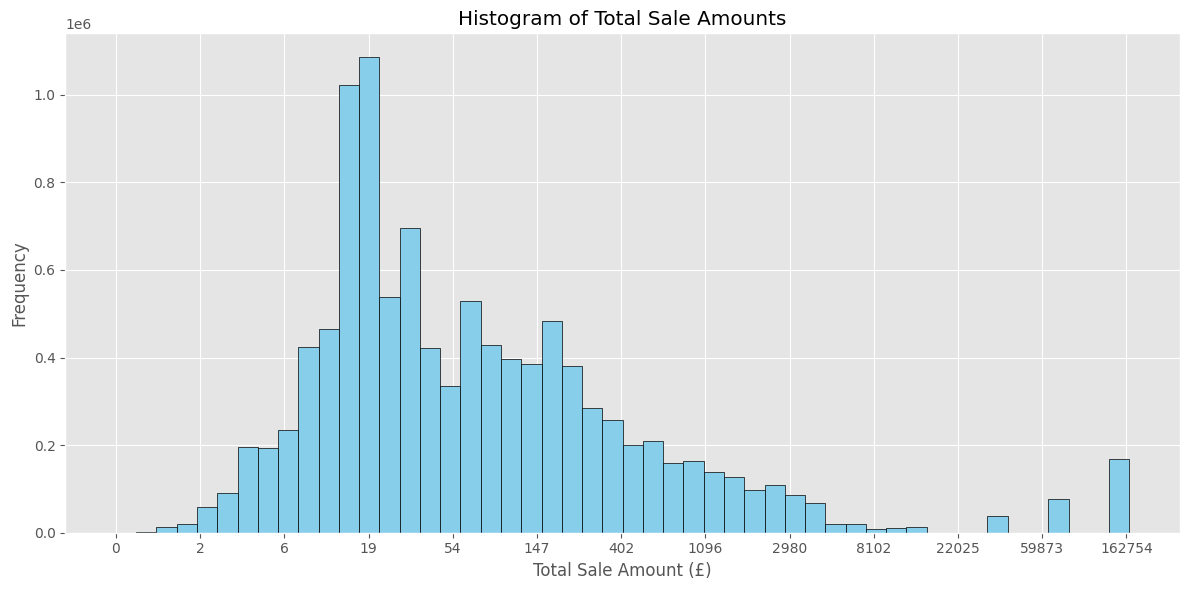

In [45]:
total_sales = sales_df['total']
#total_sales = df_filtered[(df_filtered['transaction_type'] == 'sale')]['total']

# Apply the log transformation for the histogram data
log_total_sales = np.log1p(total_sales)

plt.figure(figsize=(12, 6))
n, bins, patches = plt.hist(log_total_sales, bins=50, weights = total_sales, color='skyblue', edgecolor='black')
plt.title('Histogram of Total Sale Amounts')
plt.xlabel('Total Sale Amount (£)')
plt.ylabel('Frequency')

# Define the desired tick positions in the log scale
log_ticks = np.arange(0, np.ceil(log_total_sales.max()), 1)  # Adjust the range and step as needed

# Calculate the corresponding actual sale values for these log ticks
actual_ticks = np.expm1(log_ticks)

# Set the x-axis tick positions and labels
plt.xticks(log_ticks, [f'{x:.0f}' for x in actual_ticks]) # Format as integers

plt.tight_layout()
plt.show()

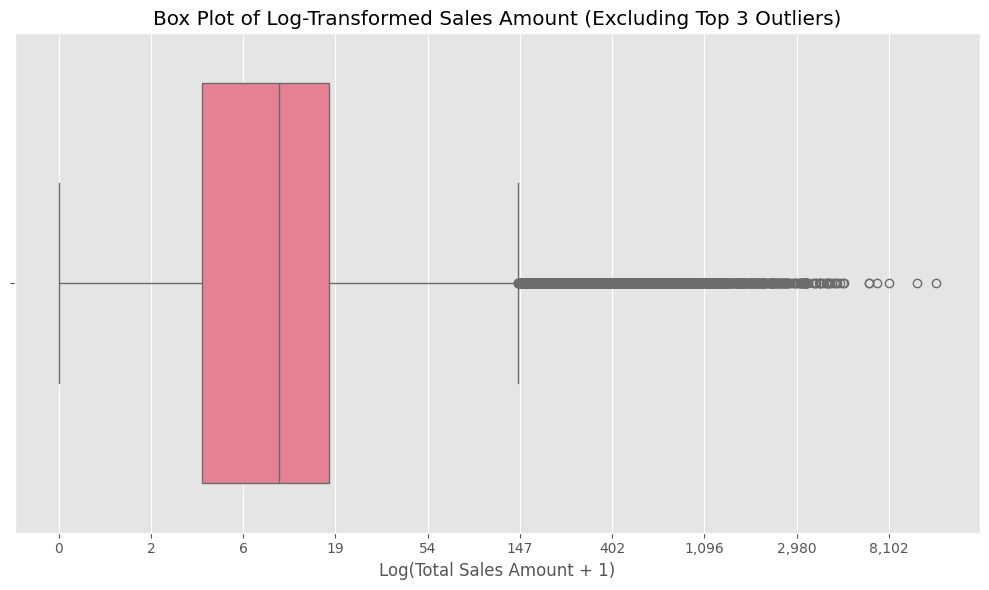

In [11]:
# Create box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=log_total_sales)
plt.title('Box Plot of Log-Transformed Sales Amount (Excluding Top 3 Outliers)')
plt.xlabel('Log(Total Sales Amount + 1)')
# Set custom x-axis labels to show actual values
plt.xticks(log_ticks, [f'{x:,.0f}' for x in actual_ticks])
plt.tight_layout()
plt.show()

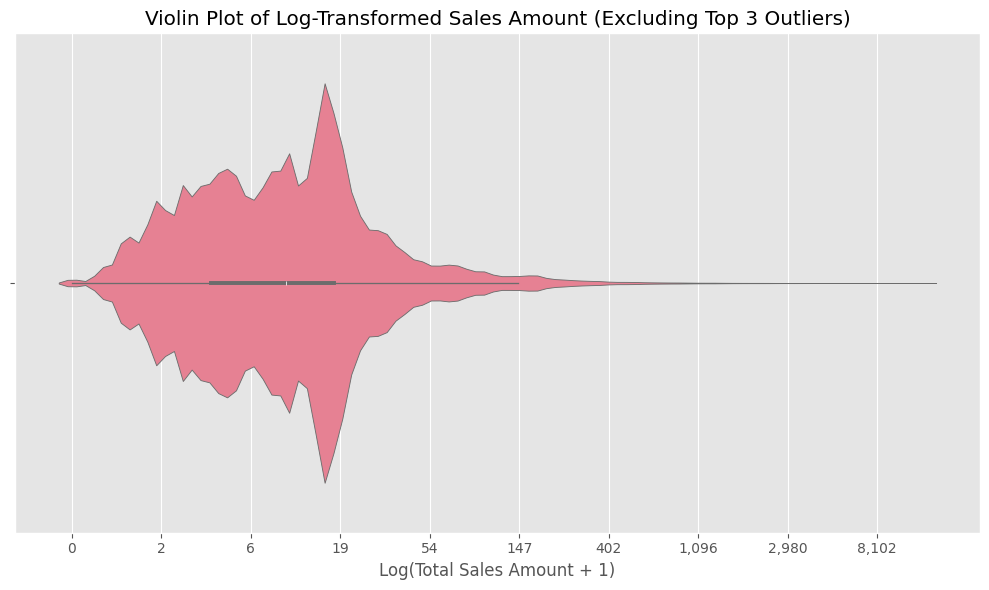

In [12]:

# Create violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x=log_total_sales)
plt.title('Violin Plot of Log-Transformed Sales Amount (Excluding Top 3 Outliers)')
plt.xlabel('Log(Total Sales Amount + 1)')
# Set custom x-axis labels to show actual values
plt.xticks(log_ticks, [f'{x:,.0f}' for x in actual_ticks])
plt.tight_layout()
plt.show()

In [6]:
print("\n4. Temporal Analysis")
print("=" * 50)
print("Date Range of Transactions:")
print(f"Start Date: {df['invoice_date'].min()}")
print(f"End Date: {df['invoice_date'].max()}")



4. Temporal Analysis
Date Range of Transactions:
Start Date: 2010-12-01 08:26:00
End Date: 2011-12-09 12:50:00


In [14]:
daily_sales = sales_df.groupby(sales_df['invoice_date'].dt.date)['total'].sum().reset_index()
daily_sales.columns=['date','total_sales']
daily_sales['date'] = pd.to_datetime(daily_sales['date'])


In [15]:
returns_df= df[df['transaction_type']=='return']
daily_returns= returns_df.groupby(returns_df['invoice_date'].dt.date)['total'].sum().reset_index()
daily_returns.columns=['date','total_returns']
daily_returns['date'] = pd.to_datetime(daily_returns['date'])


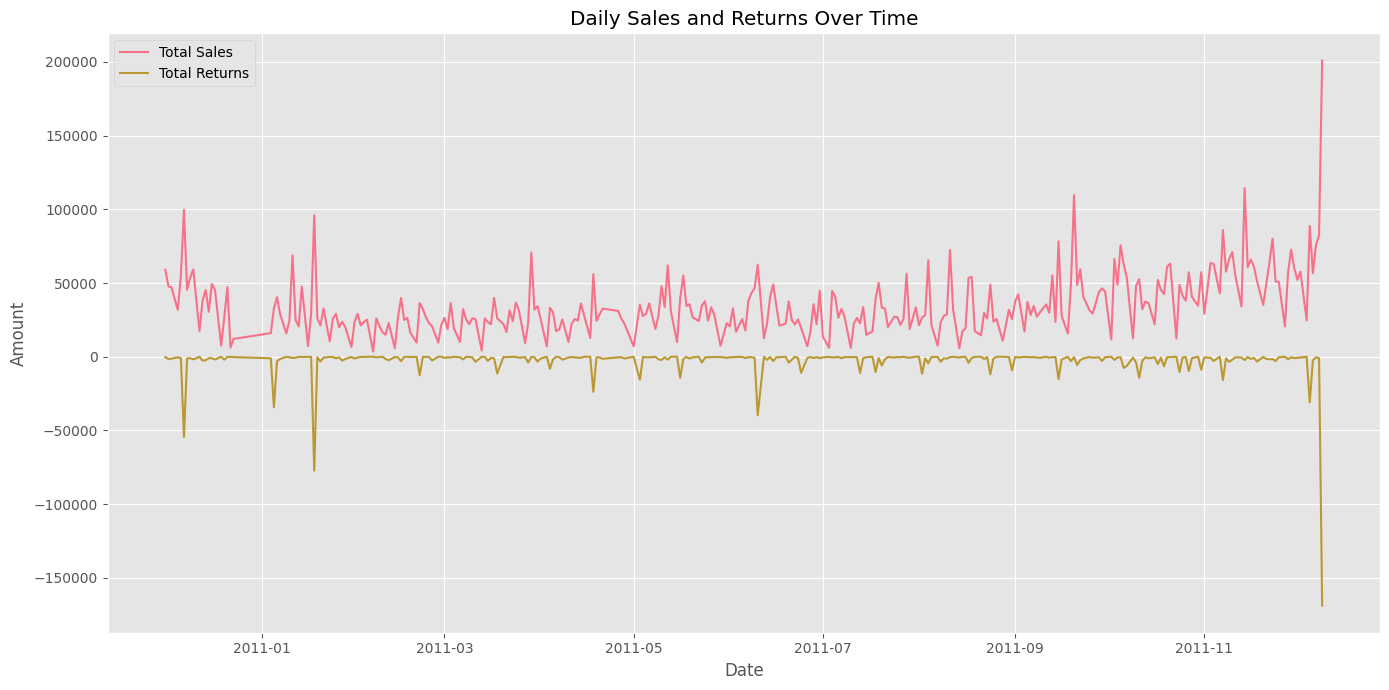

In [9]:
# Merge daily sales and returns
daily_summary = pd.merge(daily_sales, daily_returns, on='date', how='outer').fillna(0)

# Plot
plt.figure(figsize=(14, 7))
plt.plot(daily_summary['date'], daily_summary['total_sales'], label='Total Sales')
plt.plot(daily_summary['date'], daily_summary['total_returns'], label='Total Returns')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('Daily Sales and Returns Over Time')
plt.legend()
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


C:\Users\joao_\AppData\Local\Temp\ipykernel_19572\1490272012.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_df['month'] = sales_df['invoice_date'].dt.to_period('M')


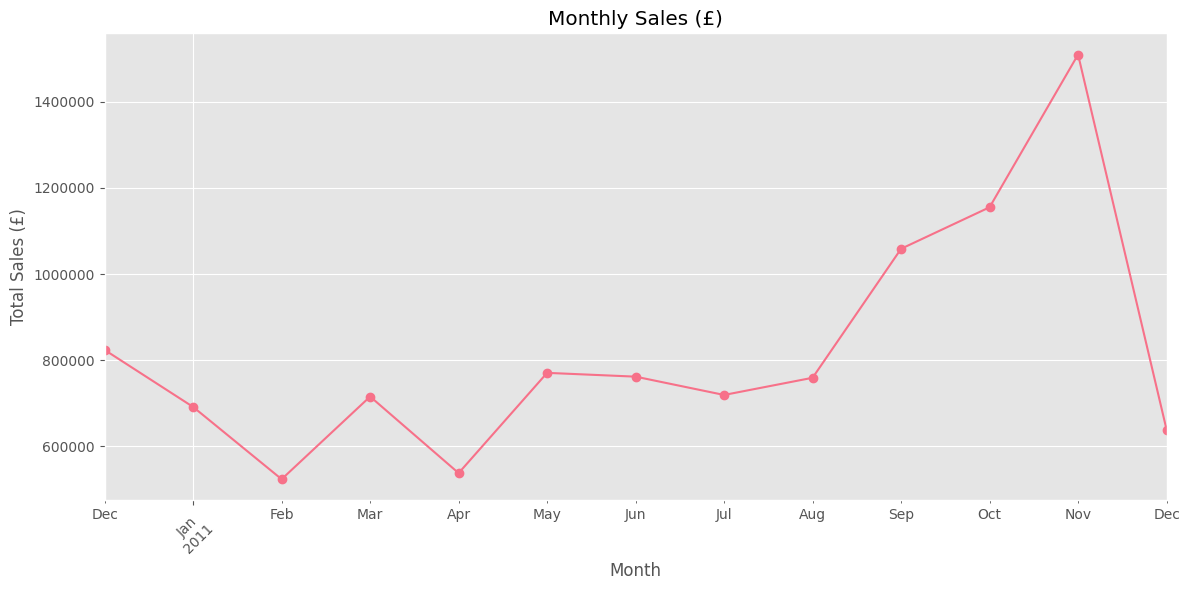

C:\Users\joao_\AppData\Local\Temp\ipykernel_19572\1490272012.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_df['date_only'] = sales_df['invoice_date'].dt.date


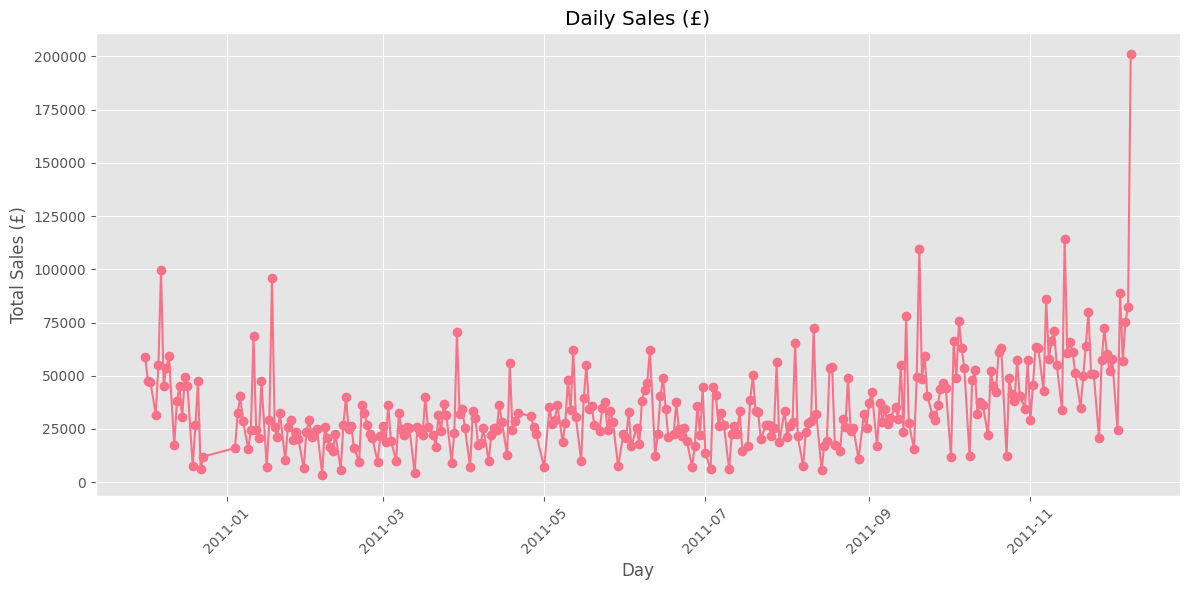

C:\Users\joao_\AppData\Local\Temp\ipykernel_19572\1490272012.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_df['dayofweek'] = sales_df['invoice_date'].dt.dayofweek


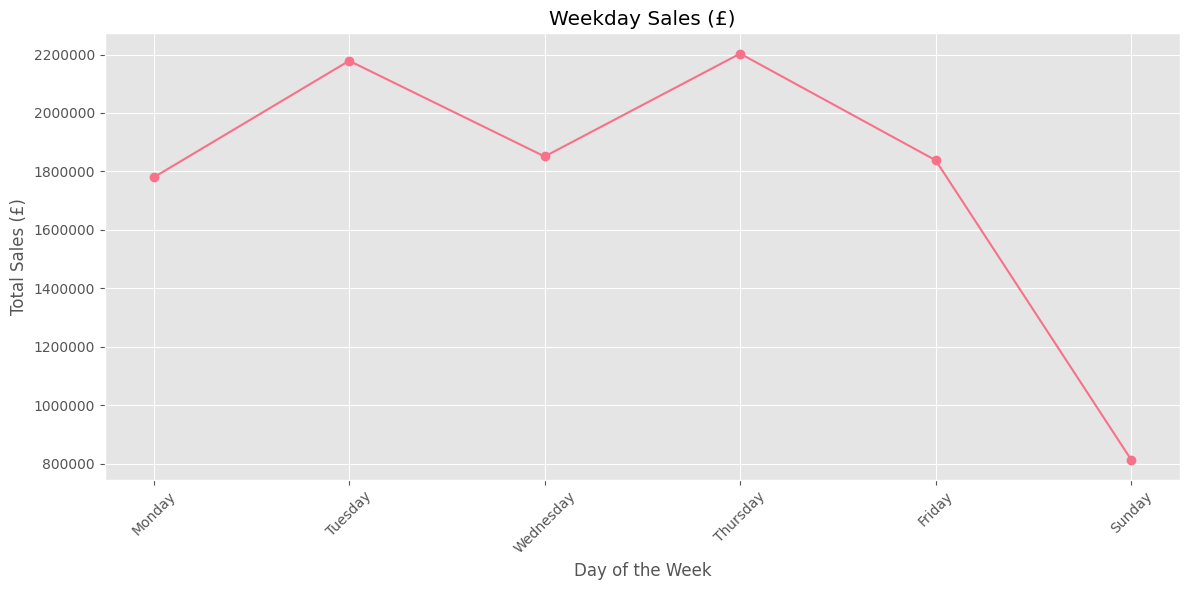

In [10]:
# Plot monthly sales
sales_df['month'] = sales_df['invoice_date'].dt.to_period('M')
monthly_sales = sales_df.groupby('month')['total'].sum()

plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='line', marker='o')
plt.title('Monthly Sales (£)')
plt.xlabel('Month')
plt.ylabel('Total Sales (£)')
plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=False))
plt.gca().ticklabel_format(axis='y', style='plain')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot daily sales
sales_df['date_only'] = sales_df['invoice_date'].dt.date
daily_sales = sales_df.groupby('date_only')['total'].sum()

plt.figure(figsize=(12, 6))
daily_sales.plot(kind='line', marker='o')
plt.title('Daily Sales (£)')
plt.xlabel('Day')
plt.ylabel('Total Sales (£)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot day of the week sales
sales_df['dayofweek'] = sales_df['invoice_date'].dt.dayofweek
day_sales = sales_df.groupby('dayofweek')['total'].sum()

day_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
           4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
day_sales.index = day_sales.index.map(day_map)

plt.figure(figsize=(12, 6))
day_sales.plot(kind='line', marker='o')
plt.title('Weekday Sales (£)')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales (£)')
plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=False))
plt.gca().ticklabel_format(axis='y', style='plain')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

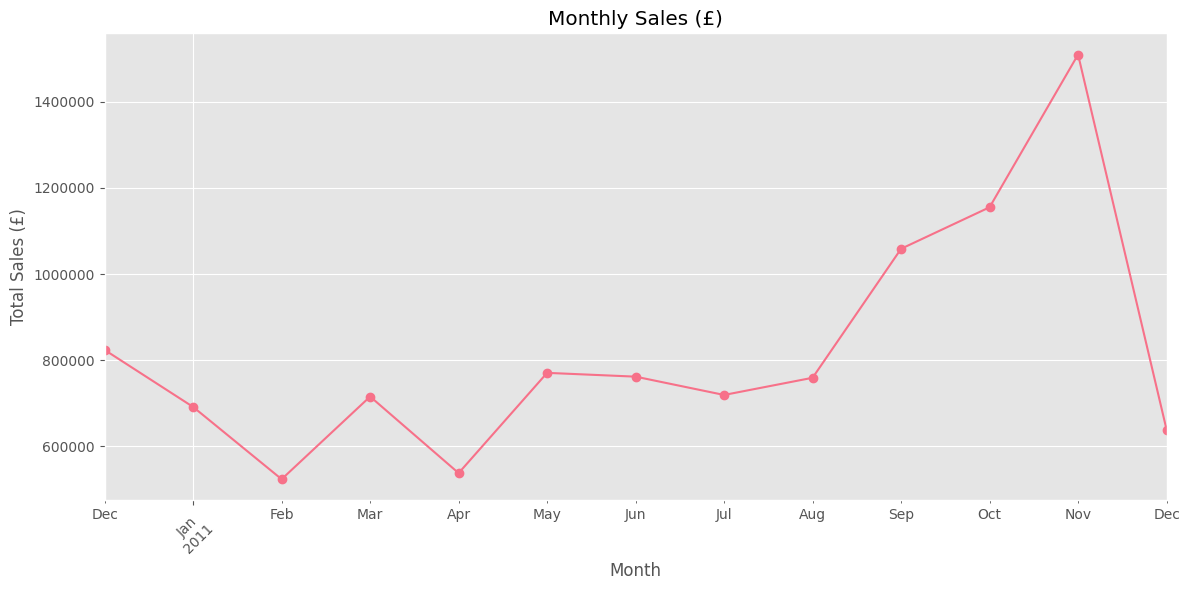

C:\Users\joao_\AppData\Local\Temp\ipykernel_19572\1221298346.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_df['date_only'] = sales_df['invoice_date'].dt.date


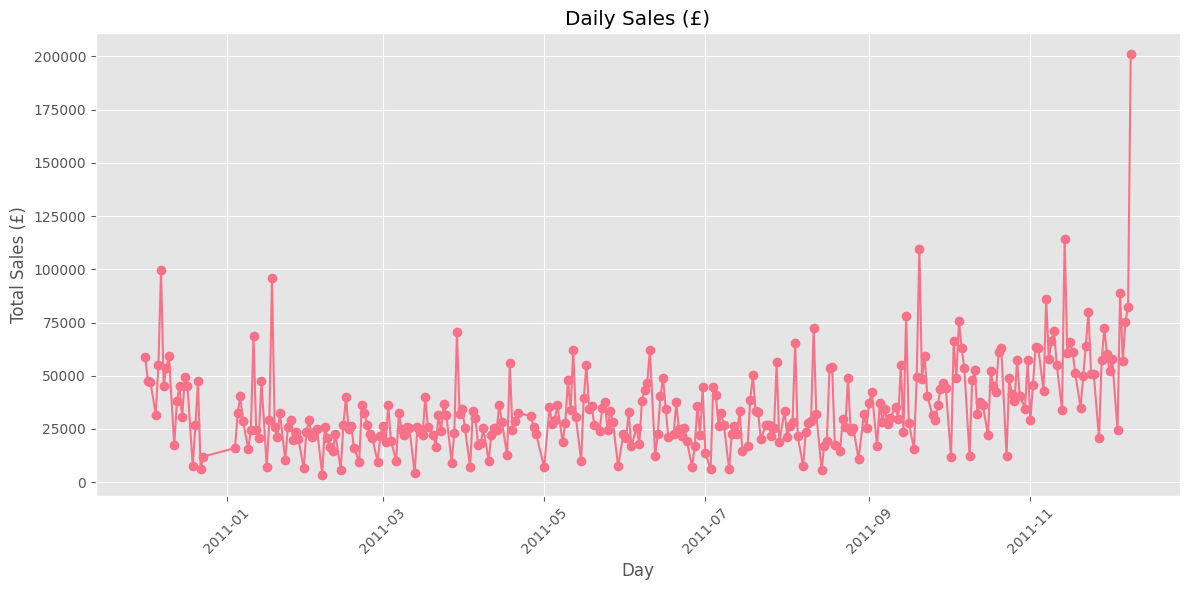

C:\Users\joao_\AppData\Local\Temp\ipykernel_19572\1221298346.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_df['dayofweek'] = sales_df['invoice_date'].dt.dayofweek


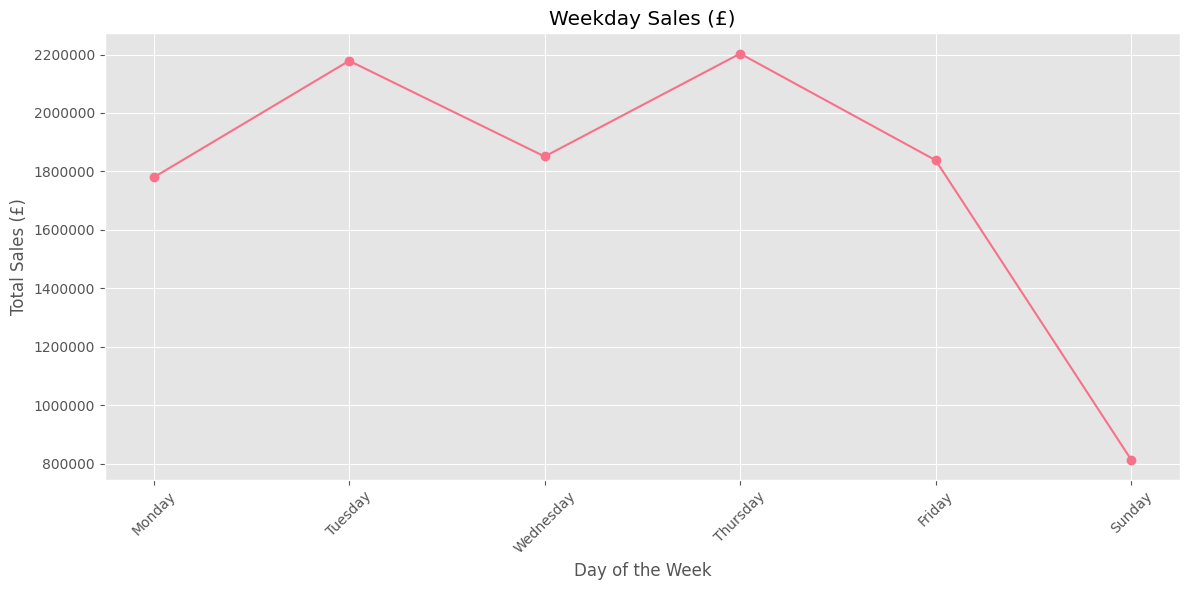

In [11]:

# Plot monthly returns
return_df['month'] = return_df['invoice_date'].dt.to_period('M')
monthly_return = sales_df.groupby('month')['total'].sum()

plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='line', marker='o')
plt.title('Monthly Sales (£)')
plt.xlabel('Month')
plt.ylabel('Total Sales (£)')
plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=False))
plt.gca().ticklabel_format(axis='y', style='plain')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot daily sales
sales_df['date_only'] = sales_df['invoice_date'].dt.date
daily_sales = sales_df.groupby('date_only')['total'].sum()

plt.figure(figsize=(12, 6))
daily_sales.plot(kind='line', marker='o')
plt.title('Daily Sales (£)')
plt.xlabel('Day')
plt.ylabel('Total Sales (£)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot day of the week sales
sales_df['dayofweek'] = sales_df['invoice_date'].dt.dayofweek
day_sales = sales_df.groupby('dayofweek')['total'].sum()

day_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
           4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
day_sales.index = day_sales.index.map(day_map)

plt.figure(figsize=(12, 6))
day_sales.plot(kind='line', marker='o')
plt.title('Weekday Sales (£)')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales (£)')
plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=False))
plt.gca().ticklabel_format(axis='y', style='plain')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

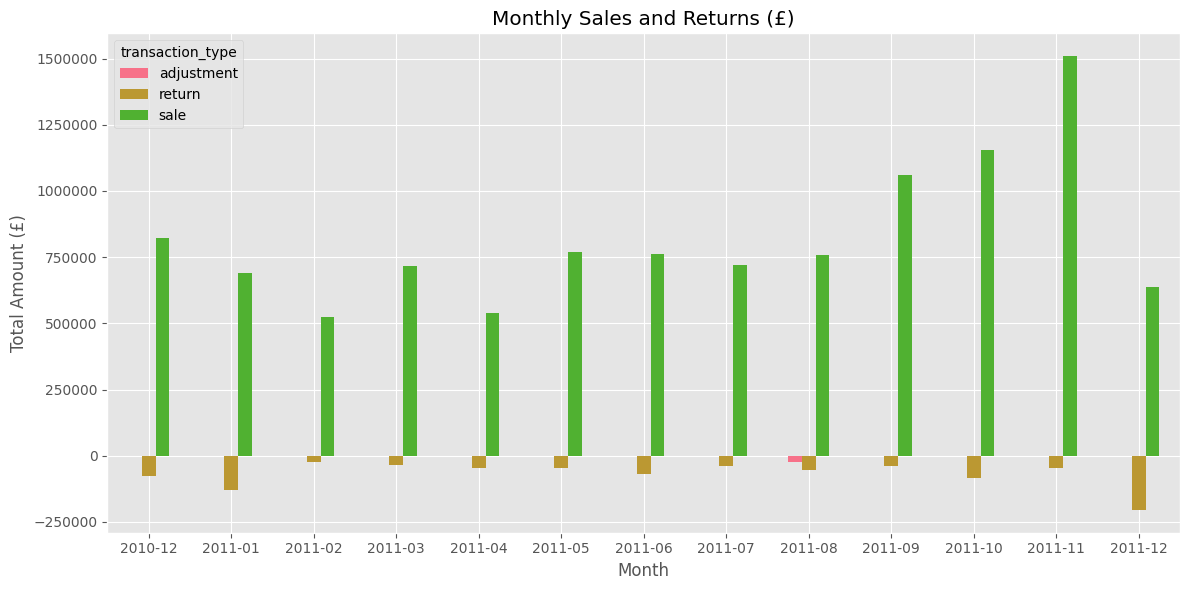

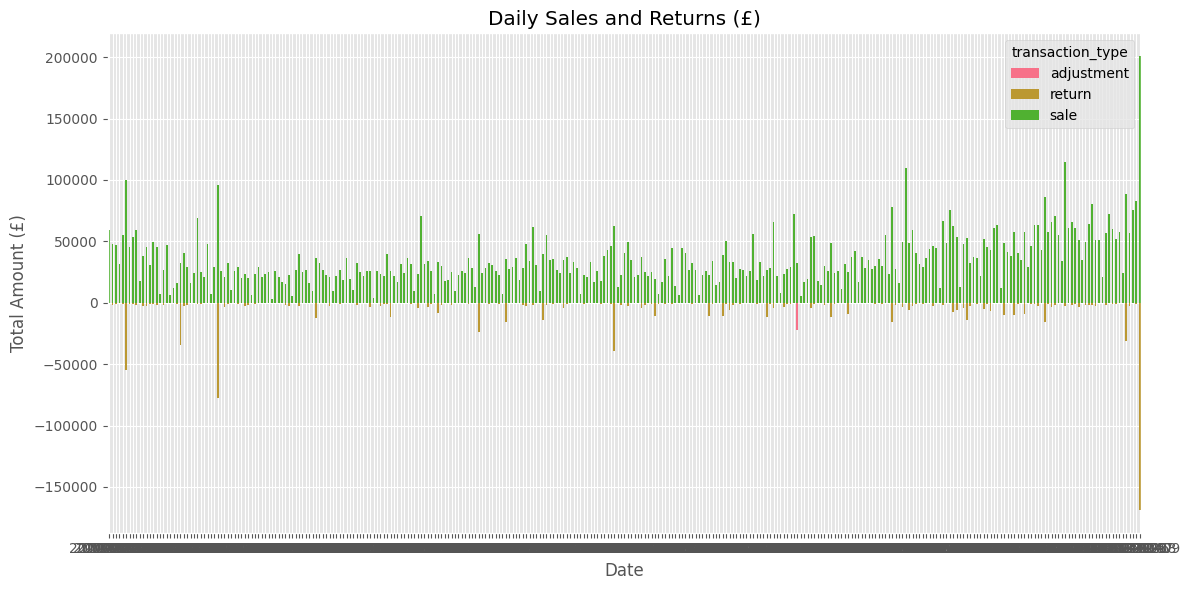

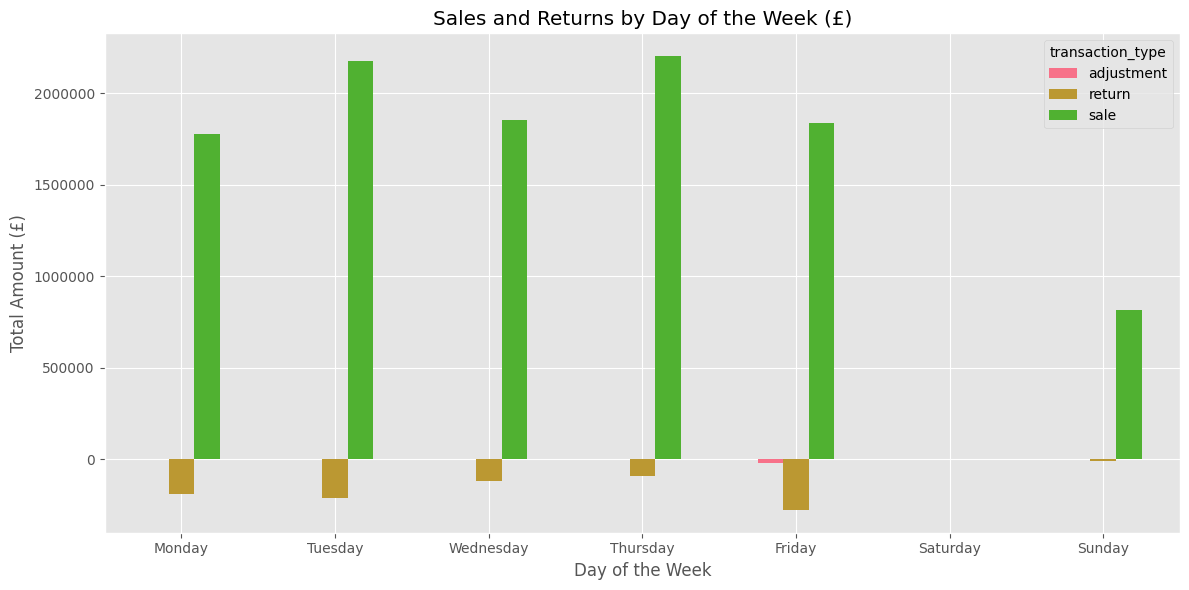

In [12]:
#Monthly Transactions Bar Chart
df['month'] = df['invoice_date'].dt.to_period('M')
monthly_transactions = df.groupby(['month', 'transaction_type'])['total'].sum().unstack().fillna(0)
monthly_transactions.plot(kind='bar', stacked=False, figsize=(12, 6))
plt.title('Monthly Sales and Returns (£)')
plt.xlabel('Month')
plt.ylabel('Total Amount (£)')
plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=False))
plt.gca().ticklabel_format(axis='y', style='plain')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#Daily Transactions Bar Chart
df['date_only'] = df['invoice_date'].dt.date
daily_transactions = df.groupby(['date_only', 'transaction_type'])['total'].sum().unstack().fillna(0)

daily_transactions.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Daily Sales and Returns (£)')
plt.xlabel('Date')
plt.ylabel('Total Amount (£)')
plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=False))
plt.gca().ticklabel_format(axis='y', style='plain')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#Day of the Week Transactions Bar Chart
df['dayofweek'] = df['invoice_date'].dt.day_name()  # Get day names directly
day_transactions = df.groupby(['dayofweek', 'transaction_type'])['total'].sum().unstack().fillna(0)

# Reorder the x-axis to be in the correct order
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_transactions = day_transactions.reindex(days_order)

day_transactions.plot(kind='bar', stacked=False, figsize=(12, 6))
plt.title('Sales and Returns by Day of the Week (£)')
plt.xlabel('Day of the Week')
plt.ylabel('Total Amount (£)')
plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=False))
plt.gca().ticklabel_format(axis='y', style='plain')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

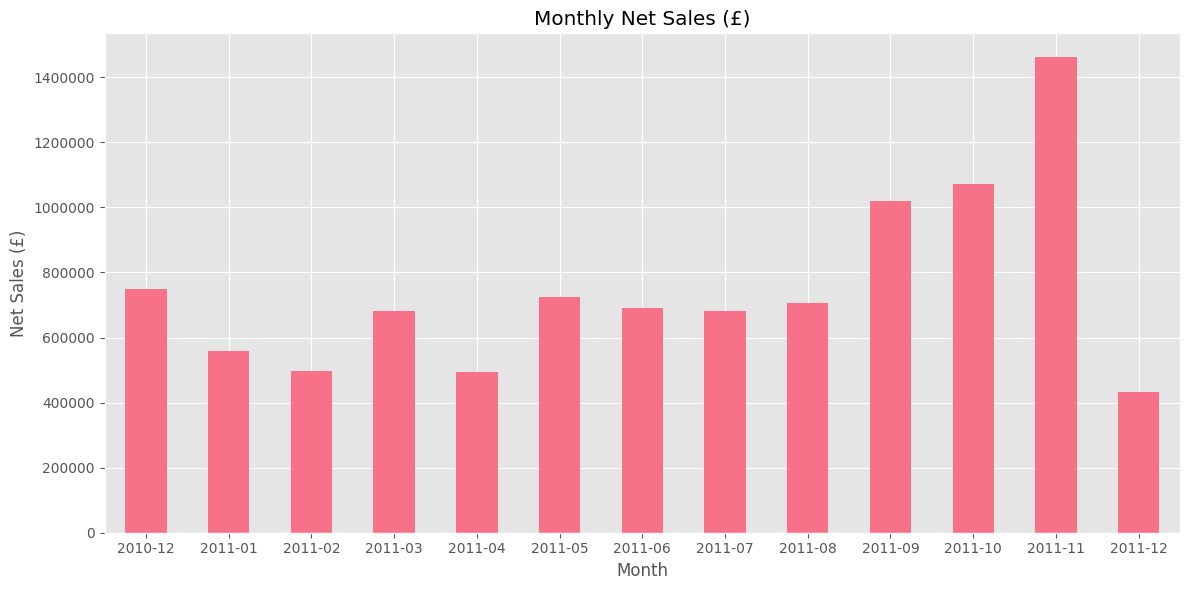

In [13]:
# Net Sales By Month
monthly_net_sales = monthly_transactions['sale'] + monthly_transactions['return'] 
plt.figure(figsize=(12, 6))
monthly_net_sales.plot(kind='bar')
plt.title('Monthly Net Sales (£)')
plt.xlabel('Month')
plt.ylabel('Net Sales (£)')
plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=False))
plt.gca().ticklabel_format(axis='y', style='plain')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

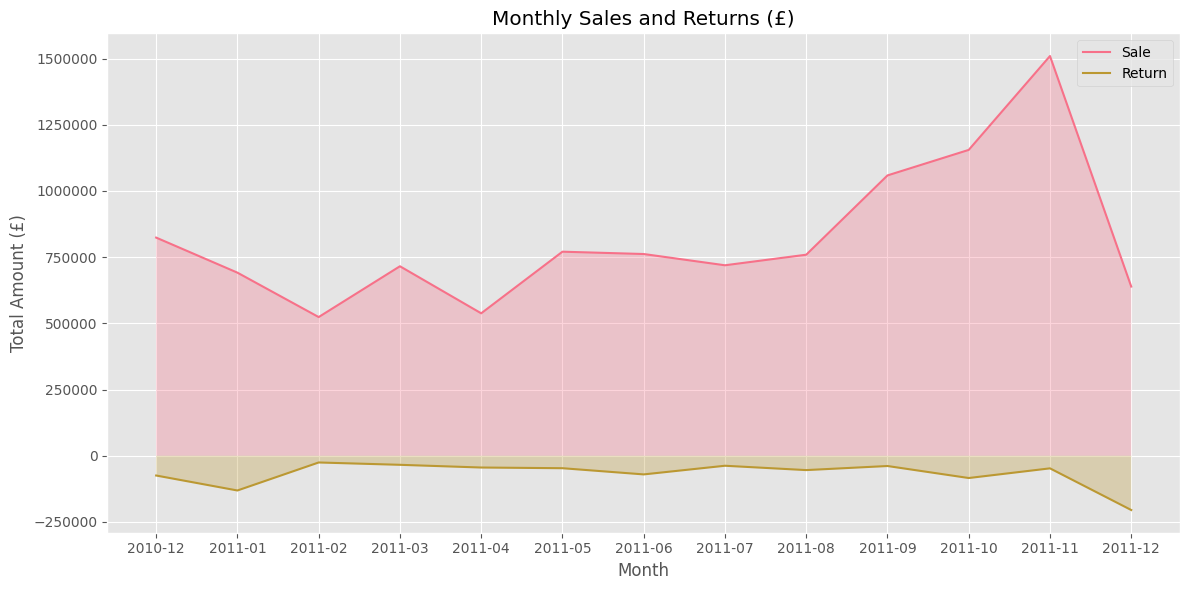

In [14]:
# Example for monthly area chart
plt.figure(figsize=(12, 6))
plt.plot(monthly_transactions.index.astype(str), monthly_transactions['sale'], label='Sale')
plt.plot(monthly_transactions.index.astype(str), monthly_transactions['return'], label='Return')
plt.fill_between(monthly_transactions.index.astype(str), 0, monthly_transactions['sale'], alpha=0.3)
plt.fill_between(monthly_transactions.index.astype(str), 0, monthly_transactions['return'], alpha=0.3)
plt.title('Monthly Sales and Returns (£)')
plt.xlabel('Month')
plt.ylabel('Total Amount (£)')
plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=False))
plt.gca().ticklabel_format(axis='y', style='plain')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()

     product_id                        description  total_quantity  \
3612      84077  world war 2 gliders asstd designs           53847   
4192     85099B            jumbo bag red retrospot           47363   
3951      84879      assorted colour bird ornament           36381   
1332      22197                     popcorn holder           36334   
530       21212    pack of 72 retrospot cake cases           36030   

      total_sales  
3612     13587.93  
4192     92356.03  
3951     58959.73  
1332     33969.46  
530      21041.00  
     product_id                         description  total_quantity  \
4774        DOT                      dotcom postage             707   
1555      22423            regency cakestand 3 tier           13025   
3290      47566                       party bunting           18006   
4218     85123A  white hanging heart t-light holder           35025   
4192     85099B             jumbo bag red retrospot           47363   

      total_sales  
4774    2062

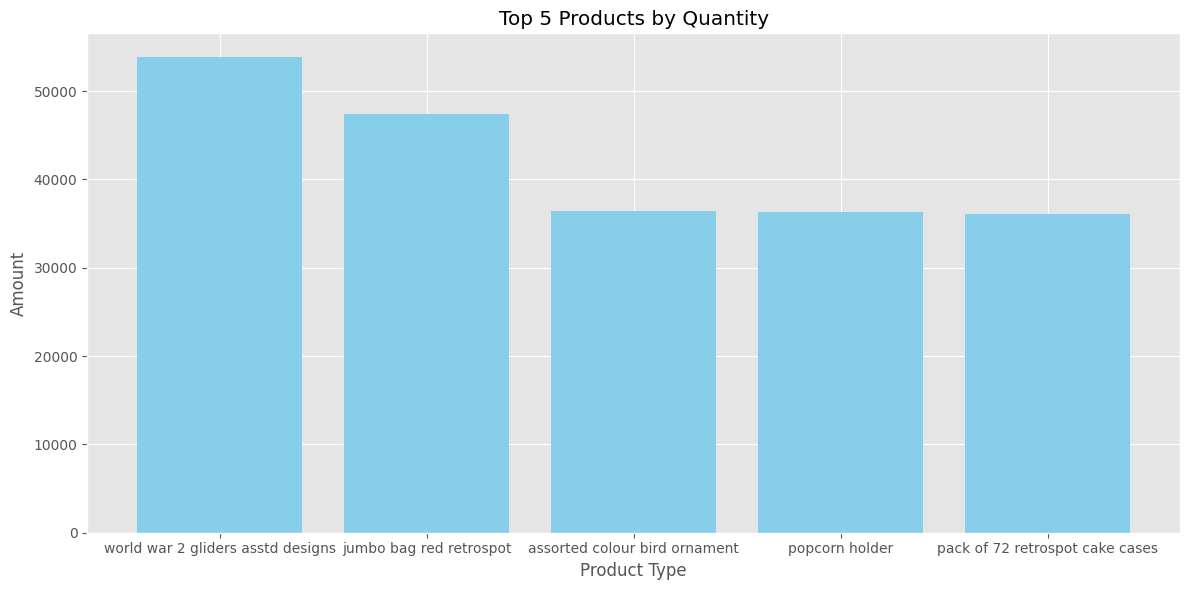

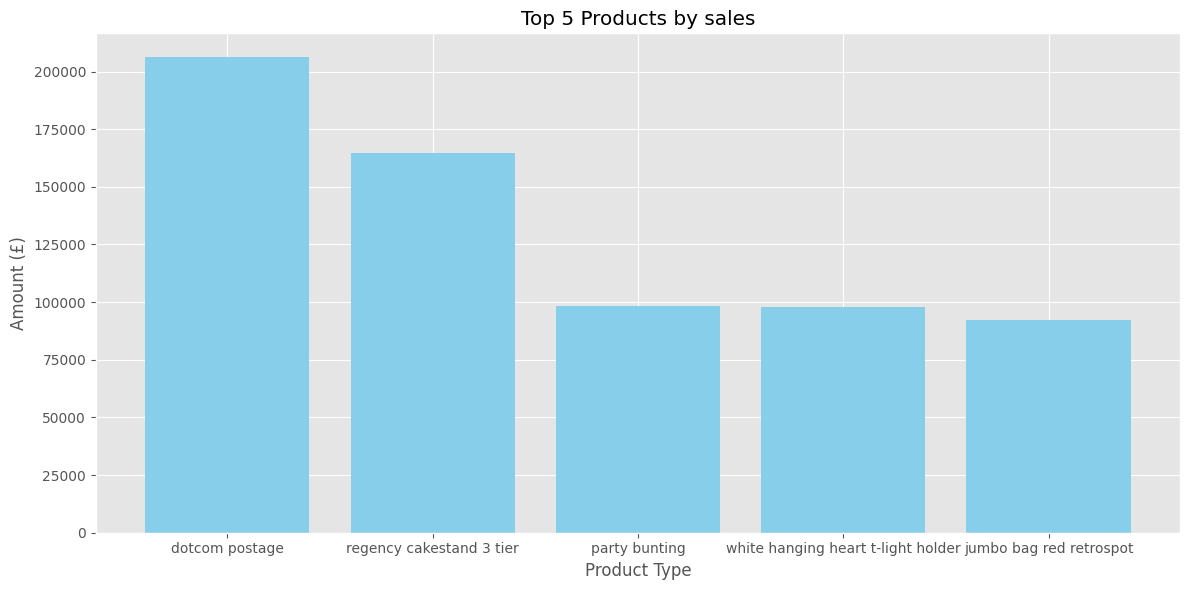

In [15]:
#Products insights

#Most popular product
product_summary = (
    df.groupby(['product_id','description']).agg(total_quantity=('quantity','sum'),total_sales=('total','sum')).reset_index()
)

#Top5 most popular products by quantity
top5_quantity= product_summary.sort_values('total_quantity', ascending=False).head(5)
print(top5_quantity)

#Top5 most popular products by total sales
top5_total = product_summary.sort_values('total_sales', ascending = False).head(5)
print(top5_total)

#plot top5 product by quantity
plt.figure(figsize= (12,6))
plt.bar(top5_quantity['description'],top5_quantity['total_quantity'],color='skyblue')
plt.title("Top 5 Products by Quantity")
plt.xlabel("Product Type")
plt.ylabel("Amount")
plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=False))
plt.gca().ticklabel_format(axis='y', style='plain')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#plot top5 product by total sales
plt.figure(figsize= (12,6))
plt.bar(top5_total['description'],top5_total['total_sales'],color='skyblue')
plt.title("Top 5 Products by sales")
plt.xlabel("Product Type")
plt.ylabel("Amount (£)")
plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=False))
plt.gca().ticklabel_format(axis='y', style='plain')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
